### Dataset preparation

In [20]:
import numpy as np
from pathlib import Path
from keras.preprocessing import image

In [24]:
p = Path("Datasets/Images/")
print(p)

Datasets\Images


In [52]:
dirs = p.glob("*")

labels_dict = {"cat":0, "dog":1,"horse":2,"human":3}

img_data = []
labels = []

for folder in dirs:
    #print(folder)
    label = str(folder).split("\\")[-1][:-1]
    
    for img_path in folder.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        img_data.append(img_array)
        labels.append(labels_dict[label])
    

In [53]:
print(len(img_data))
print(len(labels))

808
808


In [54]:
#convert data into numpy array
img_data = np.array(img_data,dtype='float32')/255.0
labels = np.array(labels)
print(img_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


### Visualize the data

In [55]:
import matplotlib.pyplot as plt

def drawing(img):
    plt.imshow(img)
    plt.show
    return



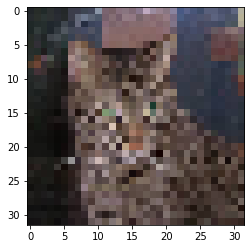

In [56]:
drawing(img_data[0])

### Randomly shuffle the data

In [57]:
import random

#we combine the img_data and labels and then shuffle them
combined = list(zip(img_data,labels))
random.shuffle(combined)

#unzip
img_data[:],labels[:] = zip(*combined)

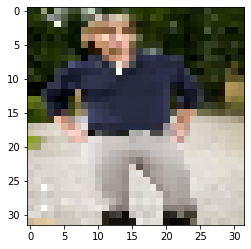

In [58]:
drawing(img_data[0])

### SVM classifier

In [112]:
class SVM:
    
    def __init__(self,c=1.0):
        self.c = c
        self.w = 0
        self.b = 0
        
    def hingeLoss(self,w,x,y,b):
        loss = 0.0
        
        loss += 0.5*np.dot(w,w.T)
        
        m = x.shape[0]
        
        for i in range(m):
            
            ti = y[i]*(np.dot(w,x[i].T)+b)
            loss += self.c * max(0,1-ti)
            
        return loss[0][0]
    
    def fit(self,x,y,learning_rate=0.00001,batch_size=100,maxItr=1000):
        
        no_of_features = x.shape[1]
        no_of_samples = x.shape[0]
        
        c = self.c
        n = learning_rate
        
        #init model parameters
        w = np.zeros((1,no_of_features))
        bias = 0
        
        #initial loss
        #print(self.hingeLoss(w,x,y,bias))
        
        #Training part
        losses = []
        
        for i in range(maxItr):
            
            l = self.hingeLoss(w,x,y,bias)
            
            losses.append(l)
            
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #batch gradient descent with random shuffling
            
            for batch_start in range(0,no_of_samples,batch_size):
                gradw = 0
                gradb =0
                
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti = y[i]*(np.dot(w,x[i].T) + bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*y[i]*x[i]
                            gradb += c*y[i]
                            
                w = w -n*w + n*gradw
                bias = bias + n*gradb
         
        
        self.w = w
        self.b = bias
        return w,bias,losses

### Convert the data for one-for-one classification

In [113]:
m = img_data.shape[0]
img_data = img_data.reshape(m,-1)
print(img_data.shape,labels.shape)

(808, 3072) (808,)


In [114]:
classes = len(np.unique(labels))
print(classes)

4


In [115]:
def classWiseData(x,y):
    data = {}
    
    for i in range(classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [116]:
data = classWiseData(img_data,labels)


In [117]:
def getDataPairForSVM(d1,d2):
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels
    

### Training NC2 SVM's classifiers

In [118]:
mysvm = SVM()

In [119]:
def trainSVMs():
    
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i] = {}
        for j in range(i+1,classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mysvm.fit(xpair,ypair)
            svm_classifiers[i][j] = (wts,b)
            
    return svm_classifiers

In [120]:
svm_classifiers = trainSVMs()

In [121]:
#parameters for cats and dogs
cats_dogs = svm_classifiers[0][1]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 3072)
-0.01235999999999998


### Predictions

In [122]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [126]:
def predict(x):
    
    count = np.zeros((classes,))
    
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [127]:
print(predict(img_data[0]))
print(labels[0])

3
3


In [128]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [130]:
accuracy(img_data,labels)

0.594059405940594

### SVM using sci-kit learn

In [132]:
from sklearn import svm

In [133]:
svm_ = svm.SVC(kernel='linear',C = 1.0)

In [134]:
svm_.fit(img_data,labels)
svm_.score(img_data,labels)

0.6410891089108911